In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, mean_squared_error

import sys
import pickle
sys.path.insert(0, '../')
from scripts.viz import plot_Over_xPass

In [5]:
# Load data created by features_dev.ipynb
df = pd.read_csv('pass_dataset.csv', index_col=0).drop(['period','gameClock','team.name','player.jersey_nb', 'pass.recipient.jersey_nb', 'coord_all_team', 'coord_all_adversary'], axis=1)
# Extract feature and target arrays
X, y = df.drop('completed', axis=1), df[['completed']]

In [6]:
params = {'base_score': 0.5,
 'booster': 'gbtree',
 'gamma': 1,
 'learning_rate': 0.1,
 'n_estimators': 200,
 'reg_alpha': 0.5,
 'reg_lambda': 5}

In [7]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3, train_size=2500)

In [8]:
xgb_model = xgb.XGBClassifier(**params, objective="binary:logistic", random_state = 42, scale_pos_weight = 0.4)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0.5, reg_lambda=5, ...)

In [9]:
fi = pd.DataFrame(data = {'feature' : X_train.columns, 'importance' : xgb_model.feature_importances_})
fi.sort_values('importance')

,feature,importance
17,nearest_defender_pass_line,0.034522
14,bypassed_opponents,0.034854
9,distance_receiver_sideline,0.035025
16,opponents_in_path,0.035115
7,speed_passer,0.035605
1,y_passer,0.037362
4,distance_sideline,0.038382
3,y_recipient,0.040014
15,angle,0.041559
6,distance_opponent,0.042107


In [10]:
print('CF trainig')
y_pred = xgb_model.predict(X_train)
print(confusion_matrix(y_train, y_pred))

CF trainig
[[ 235   55]
 [  54 2156]]


In [11]:
print('CF test')
y_pred = xgb_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))

CF test
[[ 36  50]
 [ 54 730]]


In [12]:
y_pred = xgb_model.predict_proba(X_train)
roc_auc_score(y_train,y_pred[:,1])

0.9838711187392729

In [13]:
y_pred = xgb_model.predict_proba(X_test)
roc_auc_score(y_test,y_pred[:,1])

0.8135233744660656

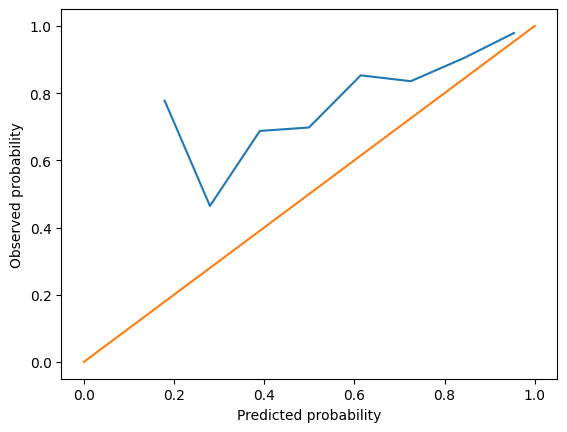

In [14]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
pos_frac, mean_val = calibration_curve(y_test,y_pred[:,1],n_bins=9)
plt.plot(mean_val, pos_frac)
plt.plot([0,1],[0,1])
plt.xlabel('Predicted probability')
plt.ylabel('Observed probability')
plt.show()

In [32]:
# Export du modèle 
xgb_model.save_model('pass_model.ubj')

### Visualisation dans l'application

In [31]:
# Application du modèle sur les données du match d'Aston Villa
df_comp = pd.read_csv('astonvilla.csv', index_col=0)
X_comp = df_comp.drop(['completed', 'period','gameClock','team.name','player.jersey_nb', 'pass.recipient.jersey_nb', 'coord_all_team', 'coord_all_adversary'], axis=1)
df_comp['xPass'] = xgb_model.predict_proba(X_comp)[:,1]
#df_comp['xPass'] *=1.05 #Pourquoi? 

df_comp = df_comp.sort_values(['period','gameClock'])
df_comp_2 = pd.concat([df_comp[df_comp['period']==1], df_comp[(df_comp['gameClock']<=15*60) & (df_comp['period']==2)]])
# df_comp_2 = df_comp_2[df_comp_2['gameClock']<=15*60]
df_comp_2['pass_nb'] = 1
df_grouped = df_comp_2[['player.jersey_nb','xPass','completed','pass_nb']].groupby('player.jersey_nb').sum()
df_grouped['xPass_mean'] = df_grouped['xPass']/df_grouped['pass_nb']
df_grouped['perf'] = df_grouped['completed']-df_grouped['xPass']
df_grouped.sort_values('perf', inplace=True)

df_grouped

,xPass,completed,pass_nb,xPass_mean,perf
player.jersey_nb,,,,,
20,9.637422,5,13,0.741340,-4.637422
2,6.252536,5,8,0.781567,-1.252536
88,13.105782,12,17,0.770928,-1.105782
19,7.008573,7,9,0.778730,-0.008573
1,7.972977,8,9,0.885886,0.027023
7,18.965652,19,22,0.862075,0.034348
10,22.783209,23,28,0.813686,0.216791
6,5.643960,6,6,0.940660,0.356040
8,9.607855,10,15,0.640524,0.392145


In [30]:
# Display KPI for coaches
player = df_grouped.iloc[-7]
plot_Over_xPass(player)